In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import os,sys,inspect

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import edhec_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display

In [3]:
def bt_mix(r1, r2, allocator, **kwargs):
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
    weights = allocator(r1, r2, **kwargs)

    if not weights.shape == r1.shape:
        raise ValueError("Allocator return weights that don't match r1")

    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [4]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
      each column is a scenario
      each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [5]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)

rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
means_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(means_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035649,0.00359,0.493272,3.807248,-0.001393,-0.000982,1.531395,0.0


In [6]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=.07, sigma=.15)
rets_eq = price_eq.pct_change().dropna()

rets_zc = zc_prices.pct_change().dropna()

In [7]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.060161,0.00516,-0.092823,2.670219,-0.002393,-0.001695,5.689286,0.0


In [8]:
summaries = erk.summary_stats(rets_7030b)

In [9]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.038210,0.118055,0.343846,4.012575,0.048036,0.061982,0.067543,-0.152968
1,0.085125,0.102572,0.156210,2.693951,0.040098,0.049626,0.522957,-0.158614
2,0.057797,0.124844,0.221903,2.671595,0.051641,0.060174,0.216555,-0.242288
3,0.037305,0.106886,-0.036584,2.390201,0.047709,0.054731,0.066391,-0.166446
4,0.038826,0.117840,-0.089085,2.761882,0.052983,0.069169,0.072748,-0.252733


In [10]:
summaries.mean()

Annualized Return          0.054744
Annualized Vol             0.107174
Skewness                   0.005380
Kurtosis                   2.926959
Cornish-Fisher VaR (5%)    0.045757
Historic CVaR (5%)         0.057639
Sharpe Ratio               0.225802
Max Drawdown              -0.205777
dtype: float64

In [11]:
def terminal_values(rets):
    """
    Returns the final values of a dollar at the end of the return period for each scenario
    """
    return (rets+1).prod()

In [14]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="EQ"),
    erk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,FI,EQ,70/30
mean,1.380928,1.994714,1.795322
std,0.120444,0.995443,0.619749
p_breach,NaN,0.056000,0.014000
e_short,NaN,0.124759,0.063744
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


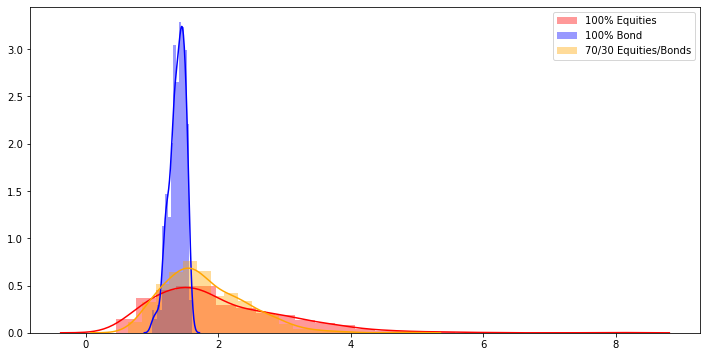

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bond")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend()

In [18]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.80, end_glide=.20)

pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="EQ"),
    erk.terminal_stats(rets_7030b, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide from 80 to 20")
], axis=1)

,FI,EQ,70/30,Glide from 80 to 20
mean,1.380928,1.994714,1.795322,1.675410
std,0.120444,0.995443,0.619749,0.445764
p_breach,NaN,0.056000,0.014000,0.004000
e_short,NaN,0.124759,0.063744,0.042991
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


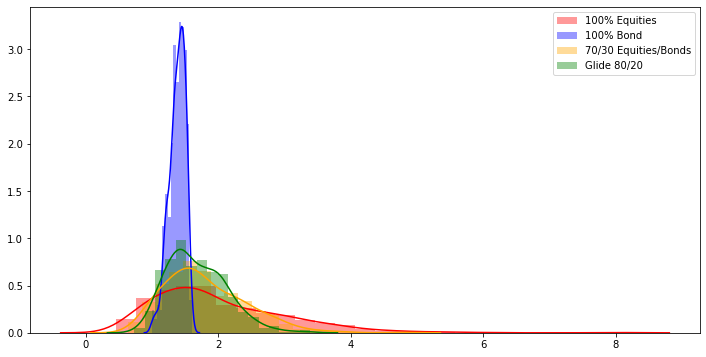

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bond")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
sns.distplot(erk.terminal_values(rets_g8020), color="green", label="Glide 80/20")
plt.legend()